In [29]:
# Custom Imports
from polymer_utils import charging as polychg
from polymer_utils.representation import PolymerDir, PolymerDirManager

# Typing and Subclassing
import copy # revise diff_mol generation to eschew this import
from typing import Any, Callable, Optional

# File I/O
from pathlib import Path
import json, pickle

# Plotting
import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage
from matplotlib.colors import Normalize, Colormap
from matplotlib.colorbar import Colorbar, ColorbarBase
                            
# Cheminformatics
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole

# Molecular Dynamics
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom

def set_rddraw_size(dim : int, aspect : float):
    '''Change image size and shape of RDMol images'''
    IPythonConsole.molSize = (int(aspect*dim), dim)   # Change image size
set_rddraw_size(900, 3/2)

POLY_PATH = Path('Polymers')
POLYAM_PATH = Path('compatible_pdbs/polyamides')

## Core functions

In [30]:
# Auxiliary
ColorMapper = Callable[[float], tuple[int, ...]]
def make_cmapper(cmap_name : str, vmin : float, vmax : float) -> ColorMapper:
    '''Wrapper for making normalized color map function'''
    cmap = plt.get_cmap(cmap_name)
    norm = Normalize(vmin, vmax)

    def cmapper(val_to_map : float) -> tuple[int, ...]:
        '''Actual colormapping function'''
        return cmap(norm(val_to_map))
    
    return cmapper

def draw_colorbar(cmap_name : str, vmin : float, vmax : float, label : str='Charge Deviation (elem. charge) - Espaloma vs AM1-Bcc-ELF10', save_path : Path=None) -> Colorbar:
    '''Create a matplotlib colorbar object with appropriate norm, color scale, and labels'''
    cmap = plt.get_cmap(cmap_name)
    norm = Normalize(vmin, vmax)
    
    fig = plt.figure()
    ax = fig.add_axes([0.9, 0.1, 0.05, 0.95])
    ticks = [vmin, 0, vmax]

    cbar = ColorbarBase(ax, orientation='vertical', cmap=cmap, norm=norm, ticks=ticks, label=label)
    
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
        plt.close()
    return cbar

# Needed
def chgd_offmol_to_flat_rdmol(offmol : Molecule) -> Chem.rdchem.Mol:
    '''Convert an OpenFF Molecule() with assigned partial charges to '''
    temp_rdmol = offmol.to_rdkit()
    for atom in temp_rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1) # need atom map numbers to preserve positional mapping in SMARTS - +1 accounts for atom #0 being "default" (not shown)
    SMARTS = Chem.MolToSmarts(temp_rdmol) # convert to labelled 
    flat_mol = Chem.MolFromSmarts(SMARTS)

    for atom in flat_mol.GetAtoms():
        prior_atom = temp_rdmol.GetAtomWithIdx(atom.GetAtomMapNum())
        atom.SetDoubleProp('PartialCharge', prior_atom.GetDoubleProp('PartialCharge')) # transfer partial charges
        # atom.SetAtomMapNum(0) # mask atom map number for prettier display

    return flat_mol

def generate_diff_mol(rdmol_1 : Chem.rdchem.Mol, rdmol_2 : Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    '''Take two charged RDKit Mols (presumed to have the same structure) and create a new Mol
      whose partial charges are the differences betwwen the two Mols' charges (atomwise)'''
    diff_mol = copy.deepcopy(rdmol_1) # duplicate first molecule as template
    for atom in diff_mol.GetAtoms():
        rdatom_1 = rdmol_1.GetAtomWithIdx(atom.GetAtomMapNum())
        rdatom_2 = rdmol_2.GetAtomWithIdx(atom.GetAtomMapNum())
        chg_diff = rdatom_1.GetDoubleProp('PartialCharge') - rdatom_2.GetDoubleProp('PartialCharge')

        atom.SetDoubleProp('ChargeDelta', chg_diff)
        atom.ClearProp('PartialCharge')    # reset partial charge and ...
        atom.ClearProp('molAtomMapNumber') # atom map num for greater visual and data clarity

    return diff_mol

def draw_rdmol_heatmap(rdmol : Chem.rdchem.Mol, cmap : Colormap, norm : Normalize, prop : str='PartialCharge', save_path : Path=None, img_size : tuple[int, int]=(1_000, 1_000)) -> IPyImage:
    '''Take a charged RDKit Mol and color atoms based on the magnitude of their charge'''
    colors = {
        atom.GetIdx() : cmap(norm(atom.GetDoubleProp(prop)))
            for atom in rdmol.GetAtoms()
    }
    atom_nums = [idx for idx in colors.keys()]

    draw = rdMolDraw2D.MolDraw2DCairo(*img_size) # or MolDraw2DCairo to get PNGs
    rdMolDraw2D.PrepareAndDrawMolecule(draw, rdmol, highlightAtoms=atom_nums, highlightAtomColors=colors)
    draw.FinishDrawing()
    img_bytes = draw.GetDrawingText()

    if save_path is not None:
        with save_path.open('wb') as img:
            img.write(img_bytes)
    return IPyImage(img_bytes)

def add_colorbar_to_image(img_path : Path, cmap : Colormap, norm : Normalize, ticks : Optional[list[float]]=None, dim : int=8, label : str='', overwrite : bool=False) -> None:
    '''Adds a colorbar to an existing image'''
    fig, ax = plt.subplots(figsize=(dim, dim))
    im = ax.imshow(plt.imread(img_path))
    ax.set_axis_off()

    cax = fig.add_axes([0.9, 0.1, 0.05, 0.8])
    cbar = ColorbarBase(cax, orientation='vertical', cmap=cmap, norm=norm, ticks=ticks, label=label)

    if overwrite:
        fig.savefig(img_path, bbox_inches='tight') # overwrite original with modified image
        plt.close()
    else:
        plt.show()

def charge_delta_heatmap(offmol1 : Molecule, offmol2 : Molecule, cmap_name : str, save_path : Path, img_size=(1_000, 1_000), dim : int=8,
                          label : str='Charge Deviation (elem. charge): AM1-BCC-ELF10 - Espaloma') -> Chem.rdchem.Mol:
    '''Takes two OpenFF molecules charged with different partial charging methods and creates a heatmapped image of the discrepancies in charges'''
    flat_mol_oe = chgd_offmol_to_flat_rdmol(offmol1)
    flat_mol_esp = chgd_offmol_to_flat_rdmol(offmol2)
    diff_mol = generate_diff_mol(flat_mol_oe, flat_mol_esp)

    deltas = np.array([atom.GetDoubleProp('ChargeDelta') for atom in diff_mol.GetAtoms()])
    vmin, vmax = deltas.min(), deltas.max()
    
    cmap = plt.get_cmap(cmap_name)
    norm = Normalize(vmin, vmax)
    ticks = [vmin, 0, vmax]

    draw_rdmol_heatmap(diff_mol, cmap=cmap, norm=norm, prop='ChargeDelta', save_path=save_path, img_size=img_size)
    add_colorbar_to_image(save_path, cmap=cmap, norm=norm, ticks=ticks, dim=dim, label=label, overwrite=True)

## Generating monomer files for polyamides

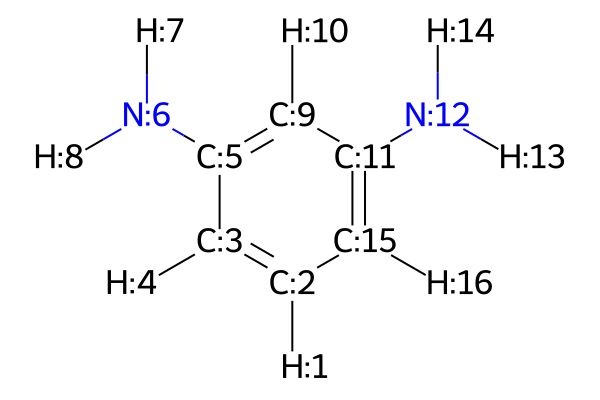

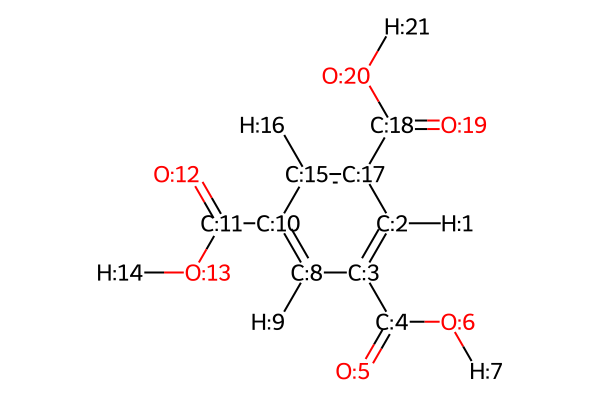

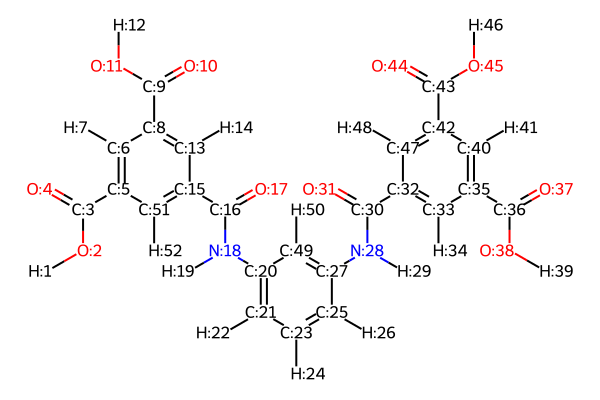

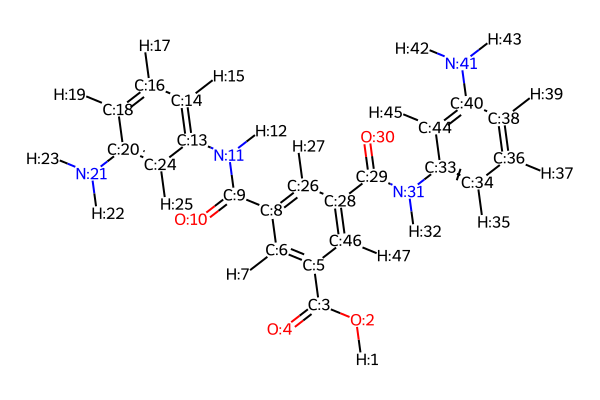

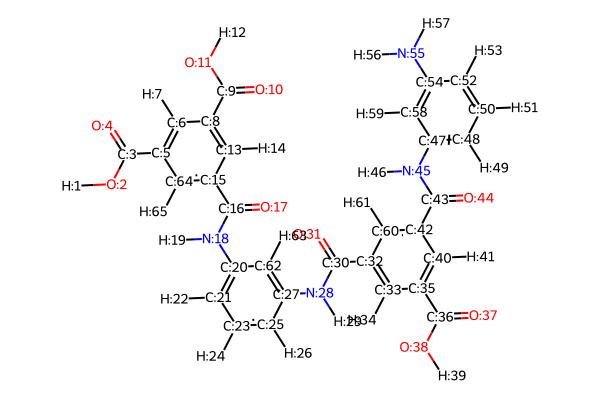

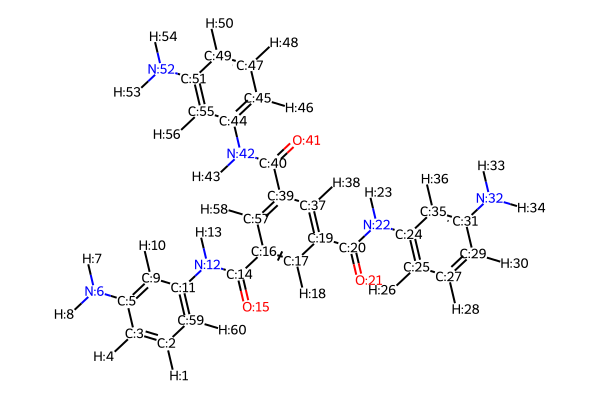

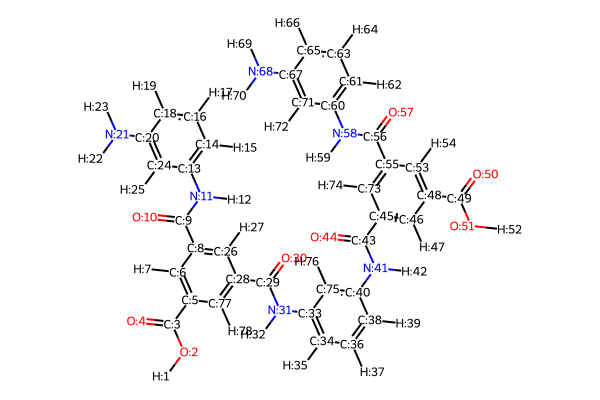

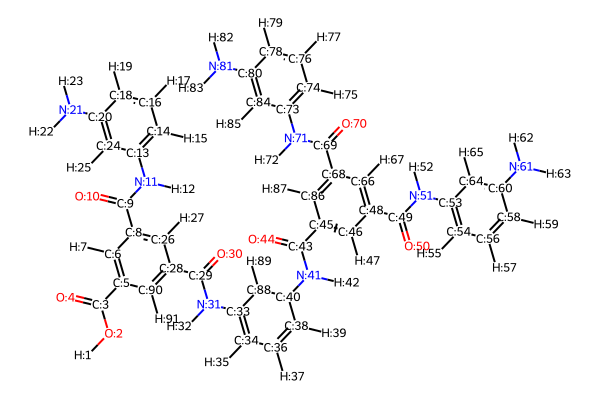

In [85]:
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [89]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

## Testing loading of polyamides using monomer spec

In [76]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

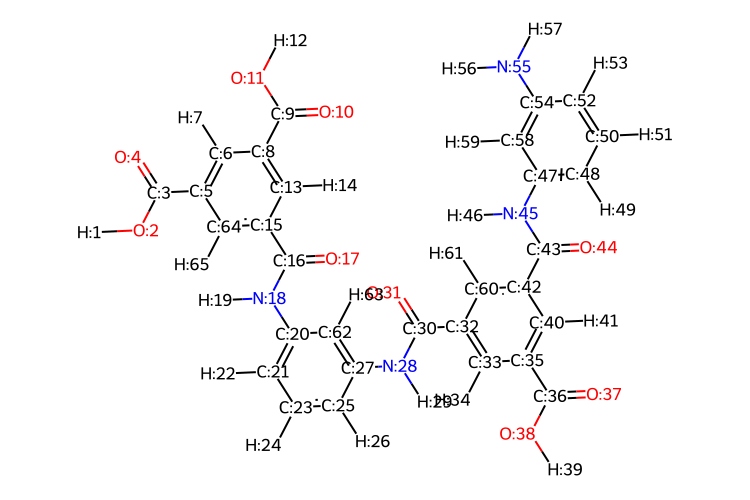

In [88]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Generating heatmaps for polyamides

In [118]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
PAM_COLL_PATH = Path('Polyamides')
pam_mgr = PolymerDirManager(PAM_COLL_PATH)

In [121]:
outdir = Path('pcharge_heatmaps/polyamides')
outdir.mkdir(exist_ok=True)

cmaps = [
    'seismic',
    'turbo',
    # 'rainbow',
    # 'terrain',
    # 'BrBG',
    # 'cool',
    # 'spring',
    # 'plasma'
]

for pam_pdir in pam_mgr.mol_dirs_list:
    offmol_esp = Molecule.from_file(pam_pdir.info.structure_file)
    cmol_esp = polychg.generate_molecule_charges(offmol_esp, toolkit_method='espaloma', partial_charge_method='espaloma-am1bcc', force_match=False) # perform AM1BCC with Espaloma

    offmol_oe = Molecule.from_file(pam_pdir.info.structure_file) # need to make separate copies so charges don;t get assigned to the same molecule
    cmol_oe = polychg.generate_molecule_charges(offmol_oe, toolkit_method='openeye',   partial_charge_method='am1bccelf10'    , force_match=False) # perform AM1BCC with OpenEye

    pkl_path = pam_pdir.pkl/f'{pam_pdir.mol_name}.pkl'
    with pkl_path.open('wb') as pkl_buf:
        pickle.dump(cmol_oe, pkl_buf)
    pam_pdir.info.pickle_file = pkl_path
    pam_pdir.to_file()

    for cmap in cmaps:
        save_dir = outdir/cmap
        save_dir.mkdir(exist_ok=True)

        save_path = save_dir/f'{pam_pdir.mol_name} deltas.png'
        diff_mol = charge_delta_heatmap(cmol_oe, cmol_esp, cmap_name=cmap, save_path=save_path, img_size=(1_000, 1_000))

/home/timber/Documents/Python/openff-workspace/openff-toolkit/openff/toolkit/utils/base_wrapper.py:256: IncorrectNumConformersWarning: Molecule 'Molecule with name 'UNNAMED' and SMILES '[H]c1c(c(c(c(c1[H])N([H])C(=O)c2c(c(c(c(c2[H])C(=O)O[H])[H])C(=O)N([H])c3c(c(c(c(c3[H])N([H])[H])[H])[H])[H])[H])[H])N([H])[H])[H]'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  warnings.warn(wrong_confs_msg, IncorrectNumConformersWarning)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'
[18:31:25] 

****
Range Error
idx
Violation occurred on line 213 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 47 < 47
****



RuntimeError: Range Error
	idx
	Violation occurred on line 213 in file Code/GraphMol/ROMol.cpp
	Failed Expression: 47 < 47
	RDKIT: 2022.09.5
	BOOST: 1_78


## Generating heatmaps for simple_polymers

In [ ]:
mgr = PolymerDirManager(POLY_PATH)
cmaps = [
    'seismic',
    'turbo',
    # 'rainbow',
    # 'terrain',
    # 'BrBG',
    # 'cool',
    # 'spring',
    # 'plasma'
]

for completed_mol in mgr.all_completed_sims:
    pdir = mgr.mol_dirs[completed_mol]

    openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdir.info.structure_file), pdir.monomer_file_ranked, strict=True, verbose=False)
    offmol = next(openff_topology.molecules) # get the first molecule (assumed to be the polymer of interest)
    cmol_esp = polychg.generate_molecule_charges(offmol, toolkit_method='espaloma' ,partial_charge_method='espaloma-am1bcc') # perform AM1BCC

    with pdir.info.pickle_file.open('rb') as mol_pkl:
        cmol_oe = pickle.load(mol_pkl)

    for cmap in cmaps:
        save_dir = Path(f'pcharge_heatmaps/{cmap}')
        save_dir.mkdir(exist_ok=True)

        save_path = save_dir/f'{pdir.info.mol_name} deltas.png'
        diff_mol = charge_delta_heatmap(cmol_oe, cmol_esp, cmap_name=cmap, save_path=save_path, img_size=(1_000, 1_000))